# Commodity mapping with openEO and CDSE


## 1. Introduction

This notebook demonstrates how to:

- Select a spatial and temporal region using an interactive map.

- Query and retrieve a machine learning model from the STAC catalog.

- Load and normalize input satellite data using OpenEO.

- Run ML inference and visualize input and output data.

CDSE (Copernicus Data Space Ecosystem)
The CDSE is the platform hosting satellite imagery, processed data, and ML models. This notebook connects to the CDSE via OpenEO to fetch input data cubes and run processing jobs in the cloud. Make sure to create an account on the CDSE in order to be able to run this workflow: https://documentation.dataspace.copernicus.eu/Registration.html

New users to openEO are advised to first visit: https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb



## 2. Interactive Spatial and Temporal Selection

Import necessary libraries and use the interactive UI to draw a bounding box (max 20×20 km) and select a year.
This sets the spatial and temporal extent in UTM coordinates, ready for OpenEO processing. UTM coordinates are required as the workflows assumes 10m resolution products

In [9]:
import openeo
import geospatial_pipeline.config as config
import utility as utility

# Step 1: Interactive UI
ui, result = utility.interactive_configurator()
ui

Loaded 3 model coverage areas
 Loaded 200 TCD coverage areas


Retrieve the selections:

In [12]:
SPATIAL_EXTENT = result["spatial_extent"]
TEMPORAL_EXTENT = result["temporal_extent"]
CRS = result["crs"]

## 3. Fetch Model Metadata

We have created a STAC collection which contains all relevant meta information for the available models for commodity mapping. Currently we have 3 models available; 1 for Africa, 1 for South America and one for South-East Asia. You can browse the catalogue at:

https://radiantearth.github.io/stac-browser/#/external/stac.openeo.vito.be/collections/world-agri-commodities-models?.language=en

each model is represented by an item. 

In the future we aim to expand this STAC collection and add meta-information on the accuracy of each model per commodity; thereby ensuring that our models and their performance is transparant. 

Below we query the STAC catalog for the ML model relevant to your region and period:

In [13]:
model_id = utility.get_model_id(SPATIAL_EXTENT, TEMPORAL_EXTENT)

model_metdata = utility.get_model_metadata(model_id)
print(model_metdata)

STAC Item found:
  ID: WorldAgriCommodities_SoutheastAsia_v1
Model metadata retrieved.
{'ModelID': None, 'Name': None, 'Region': 'Southeast Asia', 'Countries Covered': None, 'Framework': 'ONNX', 'Input Shape': 15, 'Output Shape': 24, 'Input Channels': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'NDVI', 'VV', 'VH', 'DEM', 'lon', 'lat'], 'Output Classes': ['Background', 'Other_large_scale_cropland', 'Pasture', 'Mining', 'Other_small_scale_cropland', 'Roads', 'Forest', 'Plantation_forest', 'Coffee', 'Build_up', 'Water', 'Oil_palm', 'Rubber', 'Cacao', 'Avocado', 'Soy', 'Sugar', 'Maize', 'Banana', 'Pineapple', 'Rice', 'Wood_logging', 'Cashew', 'Tea'], 'Time of Data begins': '2020-01-01T00:00:00Z', 'Time of Data ends': '2030-12-31T00:00:00Z'}


## 4. Create the normalized input Process Graph 

Below we authenticate to the CDSE backend; as a first time user you will receive a https request to log-in when running `connection.authenticate_oidc()`. Ensure that you click the link, or log in through the web browser to continue. 

A utility function `load_input_cube` has been created which builds the required input data based on the parameters optained from the interactactive UI and preset parameters defined in `config.py`. It is advised to not change the parameters set in the configuration file.

Running this cell will create a process graph, but the job itself will not be launched yet

In [14]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.band_normalization import normalize_cube
from geospatial_pipeline.onnx_inference import run_inference
from geospatial_pipeline.tree_cover_density import add_tree_cover_density


connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


input_cube = load_input_cube(
    connection,
    spatial_extent=SPATIAL_EXTENT,
    temporal_extent=TEMPORAL_EXTENT,
    max_cloud_cover=config.MAX_CLOUD_COVER,
    resolution=config.RESOLUTION,
    quantile=config.QUANTILE,
    crs=CRS,
)


# Normalize input cube for ML inference
cube_normalised = normalize_cube(input_cube, model_id=model_id)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_id=model_id,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE,
)

# Add tree cover density layer
inference_cube = add_tree_cover_density(
    connection=connection,
    cube=inference_cube,
    spatial_extent=SPATIAL_EXTENT,
)

save_inference_cube = inference_cube.save_result(format="netCDF")

save_inference_cube

Authenticated using refresh token.


Deriving band listing from unordered `item_assets`
The specified bands ['MAP'] in `load_stac` are not a subset of the bands [] found in the STAC metadata (unknown bands: ['MAP']). Working with specified bands as is.


# 5. Load Input Data [OPTIONAL]

If you wish to investigate the input data you can execute the two cells below; these will run the actual openEO job and visualise the output of the normalization procedure

In [11]:
input_save_cube = input_cube.save_result(format="netCDF")
job = connection.create_job(
    title="test_norm_with_STAC",
    process_graph=input_save_cube,
    additional=config.JOB_OPTIONS,
)
job.start_and_wait()

0:00:00 Job 'j-2511171046454e3d93ab3b9cea60765e': send 'start'
0:00:13 Job 'j-2511171046454e3d93ab3b9cea60765e': created (progress 0%)
0:00:19 Job 'j-2511171046454e3d93ab3b9cea60765e': created (progress 0%)
0:00:25 Job 'j-2511171046454e3d93ab3b9cea60765e': created (progress 0%)
0:00:33 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:00:43 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:00:55 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:01:11 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:01:30 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:01:54 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:02:24 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:03:01 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:03:48 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progress N/A)
0:04:46 Job 'j-2511171046454e3d93ab3b9cea60765e': running (progr

<BatchJob job_id='j-2511171046454e3d93ab3b9cea60765e'>

Plotting mode: input


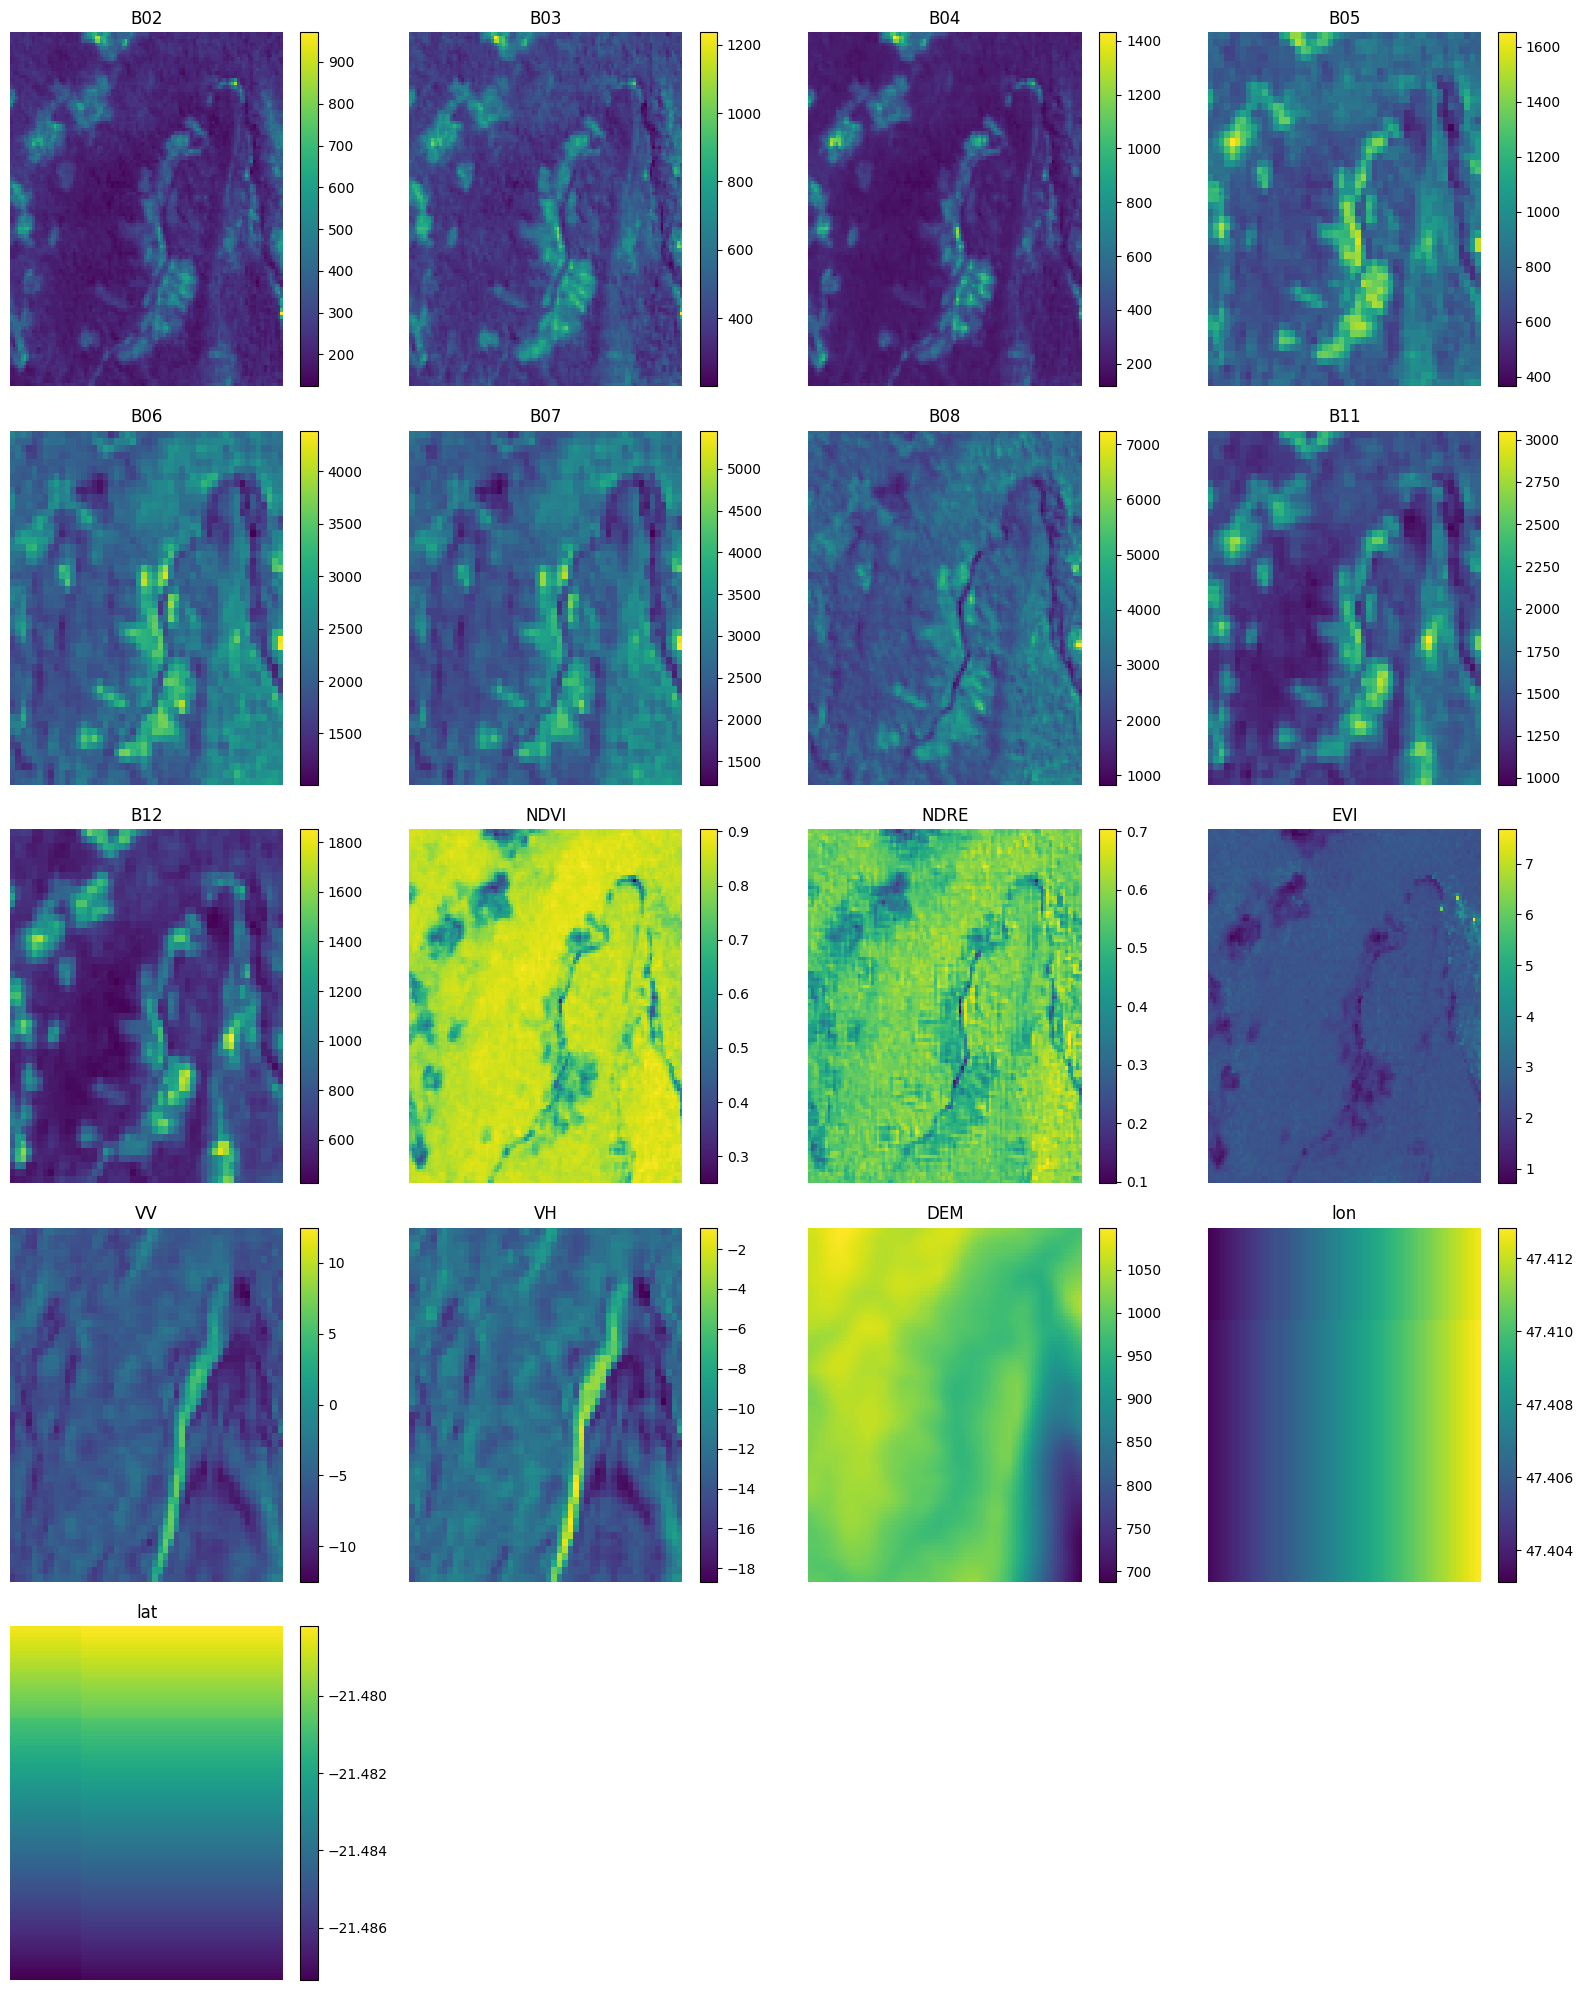

In [12]:
utility.plot_job_results(job, output_dir="~/openeo_results", time_step=0, mode="input")

# 6. Create ML Inference Process Graph

Below we use created the normalized input cube and use openEO to run the ML inference on the AOI using the `run_inference`utility function. 
Executing this cell will only create the process graph. 

In [15]:
from geospatial_pipeline.tree_cover_density import add_tree_cover_density

# Normalize input cube for ML inference
cube_normalised = normalize_cube(input_cube, model_id=model_id)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_id=model_id,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE,
)

# Add tree cover density layer
inference_cube = add_tree_cover_density(
    connection=connection,
    cube=inference_cube,
    spatial_extent=SPATIAL_EXTENT,
)

save_inference_cube = inference_cube.save_result(format="netCDF")
save_inference_cube

Deriving band listing from unordered `item_assets`
The specified bands ['MAP'] in `load_stac` are not a subset of the bands [] found in the STAC metadata (unknown bands: ['MAP']). Working with specified bands as is.


## 7. Submit Inference Cube Job

In [16]:
job = connection.create_job(
    title="Example WAC Inference with Tree Cover Density",
    process_graph=save_inference_cube,
    additional=config.JOB_OPTIONS,
)
job.start_and_wait()

0:00:00 Job 'j-2512121029094609bffd22f615904dd4': send 'start'
0:00:14 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:00:20 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:00:26 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:00:35 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:00:45 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:00:58 Job 'j-2512121029094609bffd22f615904dd4': created (progress 0%)
0:01:14 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:01:34 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:01:59 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:02:29 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:03:07 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:03:54 Job 'j-2512121029094609bffd22f615904dd4': running (progress N/A)
0:04:53 Job 'j-2512121029094609bffd22f615904dd4': running (progress

<BatchJob job_id='j-2512121029094609bffd22f615904dd4'>

# 8. Visualize Output Classification

Plotting mode: output


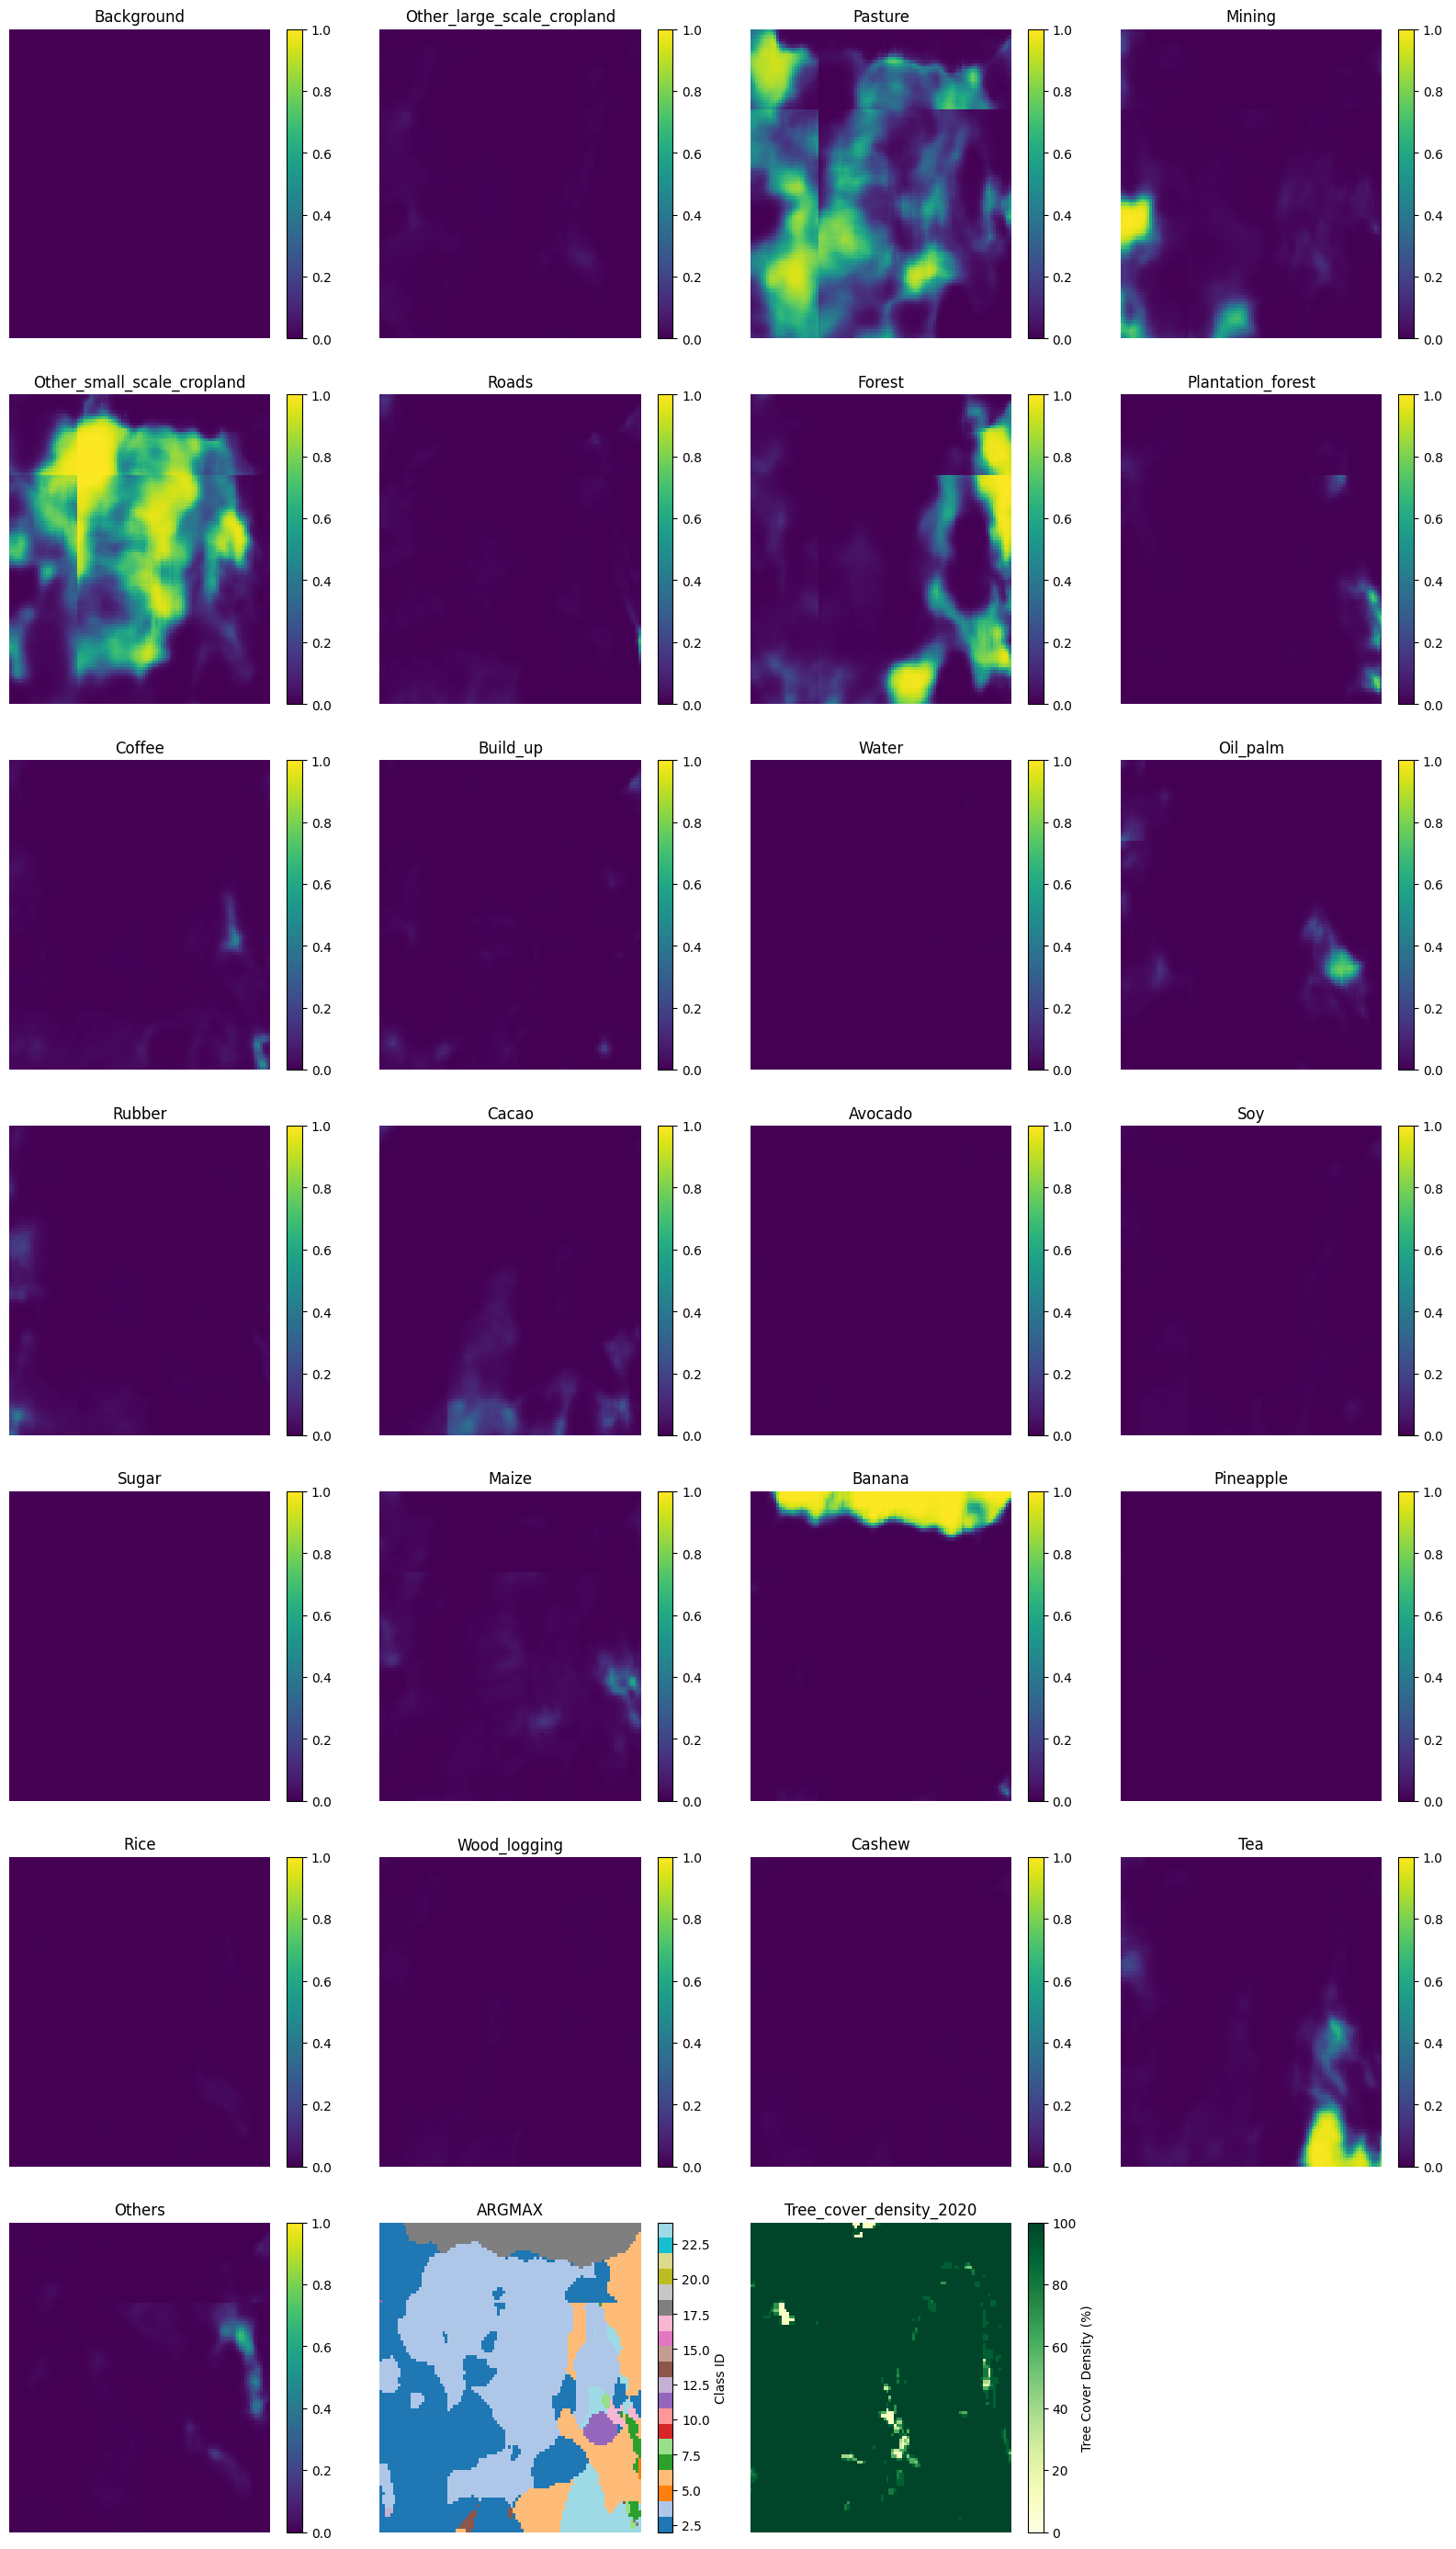

In [9]:
utility.plot_job_results(job, output_dir="~/openeo_results", time_step=0, mode="output")